# Exploring the Butcher Factor #

## Robert M. Corless ##
### Auckland, 2024-03-26 ###

### Part II of my talk for woRK 2024 ###

This file, named ButcherFactor.ipynb distributed through my github site, is a Jupyter notebook using a Maple kernel. It contains some programs associated with it useful for Hermite interpolation and for Birkhoff interpolation.



In [1]:
#
# BHIP: Barycentric Hermite Interpolation Program
#
# (c) Robert M. Corless, December 2007, August 2012
#
# Compute the barycentric form of the unique Hermite interpolant
# of the polynomial given by values and derivative values of
# p(t) at the nodes tau.
#
# CALLING SEQUENCES
#
#   ( p, gam ) := BHIP( flist, tau, t );
#   ( p, gam ) := BHIP( ftayl, tau, t, 'Taylor' = true, 'Denominator' = q );
#   ( p, gam, DD ) := BHIP( ftayl, tau, t, <opts>, 'Dmat'=true )
#
# Input:
#    flist :: list of lists of derivative values
#             [ [f[1,0],f[1,1],...,f[1,s[1]-1]],
#               [f[2,0],f[2,1],...,f[2,s[2]-1]],
#                ...
#               [f[n,0],f[n,1],...,f[n,s[n]-1]] ]
#    or, equivalently, when 'Taylor' is true,
#    ftayl :: list of lists of Taylor Coefficients,
#             same as above but divided by factorials
#             [ [f[1,0]/0!,f[1,1]/1!,...,f[1,s[1]-1]/(s[1]-1)!],
#               [f[2,0]/0!,f[2,1]/1!,...,f[2,s[2]-1]/(s[2]-1)!],
#                ...
#               [f[n,0]/0!,f[n,1]/1!,...,f[n,s[n]-1]/(s[n]-1)!] ]
#
#    As a convenience, singleton lists may be entered without []
#    If plist[i] = [] is empty, then nothing
#    is known about f at t = tau[i], and
#    tau[i] will not figure in the output.
#    Sometimes this is useful.  Not all flist[i] may
#    be empty.
#
#    tau :: list of distinct complex nodes
#           [tau[1],tau[2],...,tau[n]]
#
#    t :: name of the variable to use
#
#    Taylor :: boolean, 'true' if input is in Taylor form
#
#    Denominator :: polynomial in t, default 1 if absent
#                :: list of lists of values and derivatives
#                   or Taylor coefficients if Taylor is true
#
#    N.B.   f[i,j] = (D@@j)(f)(tau[i])  0 <= j <= s[i]-1
#          = flist[i][j+1]
#    Dmat :: boolean, 'true' if differentiation matrix desired
#
# Output:
#         p :: The unique (rational) Hermite interpolant, in barycentric
#              form.  Namely,
#              #w(t)*add(add(gam[i,j]/(t-tau[i])^(1+j)*add(p[i,j]/j!*(t-tau[i])^k)
#              This can be converted to distributed form by calling
#              distrib(p);
#
#         gam :: The Array(1..n, 0..smax-1) of coefficients
#
#         Here w(t) = mul( ( t-tau[i])^s[i], i = 1..n )
#              smax = max( op(s) )
#         and  s = list of sizes of each list in plist,
#              so s[i] is the number of pieces of
#              information at node tau[i].
#
#         DD --- Differentiation matrix on the nodes tau
#
# Processing: local Laurent series.
#             This approach is different to that of
# Reference: C. Schneider & W.Werner, "Hermite
#            Interpolation: The Barycentric Approach",
#            Computing 46, 1991, pp 35-51.
#
BHIP := proc( pin::list, tau::list, t::name,
              {Taylor::truefalse:=true}, 
              {Conditioning::truefalse:=false}, 
              {Dmat::truefalse:=false},
              {Denominator::{algebraic,list}:=1} )
        local brks, d, DD, denr, dens, dgam, 
              dr, g, gam, ghat,h, i, irow, j,
              k, mu, n, numr, nums,
              p, P, q, r, rs, rt, s, smax, sq;

        n := nops(tau);
        if nops(pin) <> n then
           error "Mismatched size of node list and data list"
        end if;

        if nops(convert(tau,set)) < n then
           error "Nodes must be distinct, with confluency explicitly specified."
        end if;

        p := map(t -> `if`(t::list,t,[t]),pin); # singletons ok
        s := map(nops,p); # confluency
        smax := max(op(s));
        if smax = 0 then
          error "At least one piece of data is necessary."
        end if;
        d := -1 + add( s[i], i=1..nops(s) );  # degree bound
        p := `if`( Taylor, p, [seq([seq(p[i][j]/(j-1)!,j=1..s[i])],i=1..n)] );

        gam := Array( 1..n, 0..smax-1 ); #default 0
        if Conditioning then
           dgam := Array( 1..n, 0..smax-1, 1..n ); #default 0
        end if;

        # The following works for n>=1
        for i to n do
            if s[i] > 0 then # ignore empty lists
               h[i] := mul( (t-tau[j])^s[j], j = 1..i-1 )*
                       mul( (t-tau[j])^s[j], j=i+1..n );
               r[i] := series( 1/h[i], t=tau[i], s[i] );
               for j to s[i] do
                  gam[i,s[i]-j] := coeff( r[i], t-tau[i], j-1) ; #op( 2*j-1, r[i] );
               end do;
               if Conditioning then
                  # We could compose a series for 1/(t-tau[k]) with
                  # what we know, but using the kernel function "series"
                  # is likely faster.
                  for k to i-1 do
                     dr[i,k] := series( s[k]/h[i]/(t-tau[k]), t=tau[i], s[i] );
                     for j to s[i] do
                       dgam[i, s[i]-j, k] := coeff( dr[i,k], t-tau[i], j-1 );
                     end do;
                  end do;
                  # We could reuse earlier series, and do one O(n^2)
                  # computation to get gam[i,-1], but it's simpler to
                  # use series (and likely faster because series is in the kernel)
                  dr[i,i] := series( 1/h[i], t=tau[i], s[i]+1 );
                  # We implicitly divide this by t-tau[i], and take
                  # coefficients one higher.
                  for j to s[i] do
                     dgam[i,s[i]-j,i] := j*coeff( dr[i,i], t-tau[i], j );
                  end do;
                  for k from i+1 to n do
                     dr[i,k] := series( s[k]/h[i]/(t-tau[k]), t=tau[i], s[i] );
                     for j to s[i] do
                       dgam[i, s[i]-j, k] := coeff( dr[i,k], t-tau[i], j-1 );
                     end do;
                  end do;
               end if;
            end if;
        end do;

        if not (Denominator::algebraic and Denominator=1) then
           # adjust gam by folding in q
           if Denominator::list then
              if nops(Denominator)<>n then
                 error "Denominator list (q) has the wrong length."
              end if;
              q :=`if`( Taylor, q, [seq([seq(q[i][j]/(j-1)!,j=1..s[i])],i=1..n)] );
           else
              ghat := Array( 1..n );
              for i to n do
                 sq := series(Denominator,t=tau[i],s[i]);
                 ghat[i] :=[seq(coeff(sq,t-tau[i],j),j=0..s[i]-1)];
              end do;
              q := [seq(ghat[i],i=1..n)];
           end if;
           ghat := Array( 1..n, 0..smax-1 );
           for i to n do
              for j from 0 to s[i]-1 do
                 ghat[i,j] := add( gam[i,j+k]*q[i][k+1], k=0..s[i]-j-1 );
              end do;
           end do;
           gam := ghat;
        end if;

        P := mul( (t-tau[i])^s[i],i=1..n)*
             add(add(gam[i,j]/(t-tau[i])^(1+j)*
                     add(p[i][1+k]*(t-tau[i])^k, k=0..j),
                     j=0..s[i]-1),
                 i=1..n );
               
        # Translated from Matlab.  Nearly working.         
        if Dmat then
          # Compute differentiation matrix
          DD := Matrix( d+1, d+1 );
          brks := [seq(add(s[j],j=1..i-1),i=1..nops(s))]; #cumsum([0,s.']);
          irow := 0;
          for k to n do
            # trivial rows
            for j to s[k]-1 do
              irow := irow+1;
              # next available row
              DD[irow,brks[k]+j+1] := j;  # result is in Taylor form
            end;
            # Nontrivial row
            irow := irow+1;
            for i in [seq(j,j=1..k-1),seq(j,j=k+1..n)] do
              for j to s[i] do
                g := 0;
                for mu from j-1 to s[i]-1 do
                    g := g + gam[i,mu]*(tau[k]-tau[i])^(j-2-mu);
                end;
                DD[irow,brks[i]+j] := g/gam[k,s[k]-1];
              end;
            end;
            DD[irow,brks[k]+2..brks[k]+s[k]] := -gam[k,0..s[k]-2]/gam[k,s[k]-1];
            # Final entry 
            DD[irow,brks[k]+1] := -add( DD[irow,brks[j]+1], j=1..nops(brks) );
            DD[irow,1..-1] := DD[irow,1..-1]*s[k];  # want Taylor form of derivative
          end;
        end if;

        
        
        return P, gam, `if`(Conditioning,dgam,NULL), `if`(Dmat,DD,NULL) ;
end proc:

#Condition number
BBHIP := proc( pin::list, tau::list, t::name, {Taylor::boolean:=false} )
   local B, gam, n, i, j, k, p, s;
   n := nops(tau);
   p := map(t -> `if`(t::list,t,[t]),pin); # singletons ok

   s := map(nops,p); # confluency

   ( p, gam ) := BHIP( pin, tau, t, ':-Taylor'=Taylor );

   return abs(mul((t-tau[i])^s[i],i=1..n))*add( add(
          abs( add( gam[i,j+k]/k!/(t-tau[i])^(j+1),j=0..s[i]-1-k) ),
          k=0..s[i]-1),
          i=1..n )
end proc:

# Generalized companion matrix pencil
# Upended October 2012
# Transposed and negated to agree with Standard Triples Paper May 2018 
# Remaining TODO: incorporate matrix polynomials via Kronecker product
CMP := proc( pin::list, tau::list, t::name, {Taylor::boolean:=false} )
   local C0, C1, gam, n, i, j, k, p, P, s, d;
   n := nops(tau);
   p := map(t -> `if`(t::list,t,[t]),pin); # singletons ok
   s := map(nops,p); # confluency
   p := `if`(Taylor, p, [seq([seq(p[i][j]/(j-1)!,j=1..s[i])],i=1..n)]);

   d := -1 + add( s[i], i=1..n );

   # P is irrelevant here, bar shape
   ( P, gam ) := BHIP( p, tau, t, ':-Taylor'=true );

   C1 := Matrix( d+2, d+2, (i,j)->`if`(i<>j,0,`if`(i=1,0,1)) );
   C0 := Matrix( d+2, d+2, 0 );
   k := 0;
   for i to n do
      for j to s[i] do
         k := k+1;
         if j < s[i] then
            C0[d+3-(k),d+3-(k+1)] := 1;
         end if;
         C0[d+3-k,d+3-k]   :=  tau[i];
         C0[1,d+3-k] := -p[i][j];
         C0[d+3-k,1] :=  gam[i,j-1];
      end do;
   end do;

   return C0, C1

end proc:

# distribution utility
distrib := proc( p )
  local w;
  if op(0,p) <> `*` then
     return p
  elif op(-1,p)::`+` then
     w := p/op(-1,p);
     return add( normal(w*t), t in [op(op(-1,p))] )
  else
     return p
  end;
end:

TPHC := proc( n, m )
   local B, Bc, ctrs, i, mx, p, plts, sx, t, x, y;
   p := [[seq((-1)^k, k = 0 .. n-1)], [seq((-1)^k, k = 0 .. m-1)]];
   B := BBHIP( p, [0,2], t );
   sx := fsolve( diff( `assuming`([simplify(B)], [t::(RealRange(0, 2))]), t ), 
   t=0.0001..1.9999 );
   if [sx] = [] then error "Failed to locate the maximum" end;
   if has(sx,t) then sx := 1; end;
   mx := eval(B, t = sx);
   Bc := eval(B, t=x+I*y );
   ctrs := mx*[seq(100^k, k = 0 .. 3)];
   plts := NULL;
   for i in ctrs do
      plts := plts, plots[implicitplot](Bc-i, x = -1.5 .. 3.5, y = -2 .. 2, colour = 
      BLACK, grid = 2*[50, 50], gridrefine = 2, view=[-1.5..3.5, -2..2], 
      scaling=CONSTRAINED )
   end do;

   return (mx, {plts});
end:

# This routine writes out the coefficients of 1 in the Hermite basis
# in reverse order with an extra zero in front RMC May 2018
# This gives us our X for the standard triple for Hermite/Lagrange linearizations
rho2x := proc( pin )
  local i, j, n, one, p, s;
  p := map(t -> `if`(t::list,t,[t]),pin); # singletons ok
  n := nops(p);
  s := map(nops,p); # confluency
  p := `if`(Taylor, p, [seq([seq(p[i][j]/(j-1)!,j=1..s[i])],i=1..n)]);
  one := Vector[row]([0,seq(op([seq(0,j=2..s[n+1-i]),1]),i=1..n)] );
end:

kilobytes used=1797, alloc=5424, time=0.36

In [2]:
#
# BHBIP: Barycentric Hermite-Birkhoff Interpolation Problem
# Procedure to solve the Hermite-Birkhoff Interpolation Problem in Maple, in Barycentric form
#
# RMC September 2009
#
# Input:
#         y    :: list of y[i], each y[i] a list of local Taylor coefficients at tau[i];  "undefined" indicates coefficient not known.
#         tau  :: list of distinct nodes tau[i]
#         t    :: point to evaluate polynomial at, or symbol/name to return polynomial in barycentric form
#
# Output:
#        if the problem is not poised, the routine returns an error message.
#
#        if t is one of tau, then a "replaced list" is returned (with tau and t), with all missing/undefined data replaced
#
#        if t is not a member of tau, then the value of the unique Hermite-Birkhoff interpolating polynomial is given at t.
#
#
# For symbolic processing, this routine uses the environment variable "Normalizer".  Setting Normalizer to "factor" will sometimes
# produce nicer results.  For floating-point data, setting it to "evalf" might be advisable.
#
# The program uses the local Laurent series algebra implemented in "series", which ought to be numerically stable, but may not be.
# More needs to be investigated here.
#
BHBIP := proc( y::list, tau::list, t, {Denominator::{operator}:=1}  )
   local A, answer, anymissing, b, B, dt, eqs, i, ii, j, jj, k, m, missing, n, R, rb, s, ser, sol, w, ycopy, z;

   # Error conditions

   n := nops(tau);
   if nops(convert(tau,set)) < n then
      error "Interpolation nodes must be distinct; use lists of Taylor coefficients to indicate confluency."
   end if;

   if nops(y) <> n then
      error "Mismatch between the number of nodes and the number of lists of local Taylor coefficients."
   end if;

   # Walk through "y" to locate undefined values, and to find confluencies s.

   s := Vector( n, 0 );
   missing := Matrix( n, n, (i,j)->false );
   anymissing := Vector(n, i->false );
   m := 0;
   for i to n do
      s[i] := nops(y[i]);
      # Dumbly looking at each one, because more than one may be undefined
      for j to s[i] do
         if y[i][j] = undefined then
            missing[i,j] := true;  # Yes, useless rewriting of conditional, but saves typing if "undefined" is replaced/extended
            anymissing[i] := true; # Yes, useless re-doing, but it saves a useless test
            m := m + 1;
         end if;
      end do;
   end do;

   w := mul( (z-tau[i])^s[i], i=1..n );
   
   if m=0 then
      warning ("Problem was apparently a pure Hermite interpolation problem.  No missing data noticed.");
   end if;
   
   
   if member(t, tau) then
      # In this case, just fill in all the missing data.
      
      
      B := add( b[k]*z^k, k=0..m-1 );
      eqs := Vector(m);
      k := 0;
      for i to n do
         if anymissing[i] then
            ser := series( Denominator(z)*B/w, z=tau[i], s[i]+1 );
            for j to s[i] do
               if missing[i,j] then
                  k := k+1;
                  eqs[k] := coeff( ser, z-tau[i], -j );
               end if;
            end do;
         end if;
      end do;

      if k<> m then error "Counted a different number of undefineds this time, Captain." end if;

      
      (A,rb) := LinearAlgebra:-GenerateMatrix( [seq(eqs[k],k=1..m)], [seq(b[k],k=0..m-1)] );
       
      dt := Normalizer(LinearAlgebra:-Determinant(A));
      userinfo(10,procname,"Determinant of matrix for multiplier coefficients is", dt );
       
      if dt = 0 then
        error "Problem appears not to be poised."
      end if;
      
      A := - LinearAlgebra:-MatrixInverse( A );
      
      
      ycopy := Array( 1..n, 1..max( seq(s[i],i=1..n) ) );
      
      k := 0;
      for i to n do
              for j to s[i] do
               if missing[i,j] then
                  k := k+1;
                  B := add( A[ell,k]*z^(ell-1), ell=1..m );
                  answer := 0;
                  for ii to n do
                     ser := series( Denominator(z)*B/w, z=tau[ii], s[ii]+1 );
                     for jj to s[ii] do
                        if not missing[ii,jj] then
                           answer := answer + Normalizer(coeff( ser, z-tau[ii], -jj ))*y[ii][jj];
                        end if;
                     end do;
                  end do;
                  ycopy[i,j] := answer;
               else
                  ycopy[i,j] := y[i][j];
               end if;
            end do;
       end do;

      return [seq( [seq(ycopy[i,j],j=1..s[i])], i=1..n )], tau, t;

   else
      # In this case, use (potentially) symbolic solution.
      B := add( b[k]*z^k, k=0..m );
      eqs := Vector(m+1);
      k   := 0;
      for i to n do
         if anymissing[i] then
            ser := series( Denominator(z)*B/w/(z-t), z=tau[i], s[i]+1 );
            for j to s[i] do
               if missing[i,j] then
                   k := k+1;
                   eqs[k] := coeff( ser, z-tau[i], -j );
               end if;
            end do;
         end if;
      end do;
      
      if k<> m then error "Counted a different number of undefineds this time, Captain." end if;
      
      eqs[m+1] := coeff( series( Denominator(z)*B/(z-t), z=t, 2 ), z-t, -1 ) + 1; # Move the w(t) to the end
      
      sol := solve( {seq(eqs[k],k=1..m+1)}, {seq(b[k],k=0..m)} );
      
      if sol = NULL or sol={} or has(sol,undefined) then
         error "Problem appears not to be poised."
      end if;
      
      # Now use the b[k] values to generate the answer.
      
      R := eval( B/w/(z-t), sol );
      
      answer := 0;
      for i to n do
         ser := series( Denominator(z)*R, z=tau[i], s[i]+1 );
         for j to s[i] do
            if not missing[i,j] then
               answer := answer + Normalizer(coeff( ser, z-tau[i], -j ))*y[i][j];
            end if;
         end do;
      end do;
      
      return eval(w,z=t)*answer;
   end if;
   
end proc:



### A Simple Example ###

I made this up.  It's only supposed to be illustrative.

        [       "1 .. 4 x 0 .. 1 Array"]

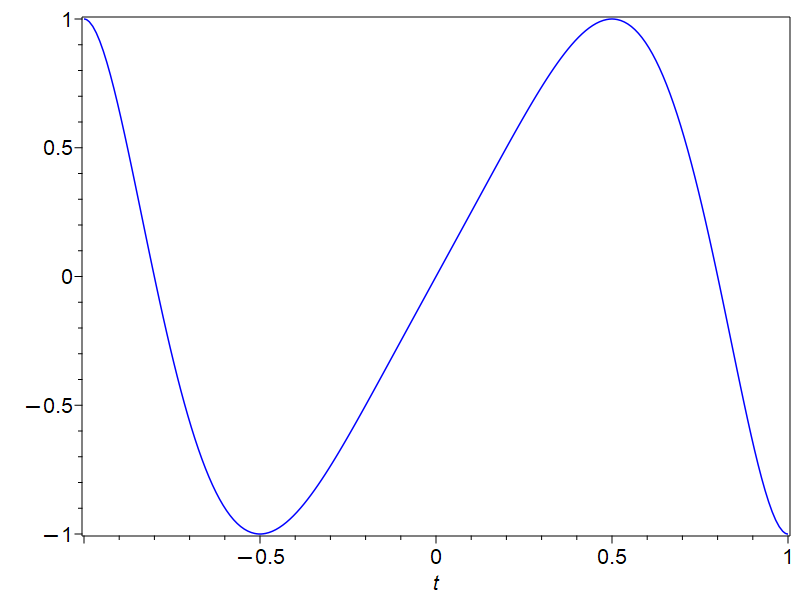

In [3]:
nodes := [-1, -1/2, 1/2, 1]:
rho := [[1, 0], [-1, 0], [1, 0], [-1, 0]]: # Hermite data
pH, barywts := BHIP(rho, nodes, t);
pHplot := plot( pH, t=-1..1, colour=blue );

In [4]:
DpH := diff(pH, t):
limit(DpH, t = -1), limit(DpH, t = -1/2);


                                     0, 0

kilobytes used=5467, alloc=10801, time=0.73

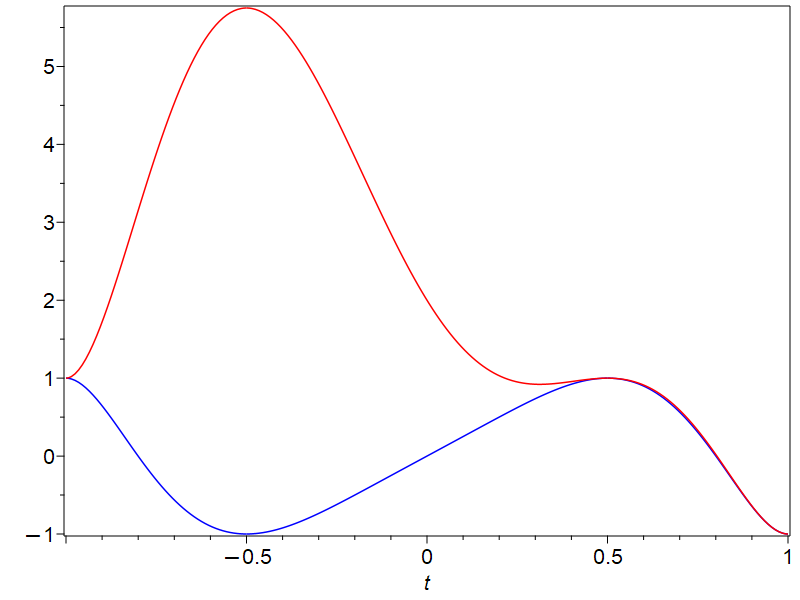

In [5]:
rhomissing := [[1, 0], [undefined, 0], [1, 0], [-1, 0]]:
pB := BHBIP(rhomissing, nodes, t):
pBplot := plot(pB, t = -1 .. 1, colour = red):
plots[display](pHplot, pBplot);

In [6]:
convert(1/((z + 1)^2*(z + 1/2)^2*(z - 1/2)^2*(z - 1)^2), parfrac, true);

4/9/(z+1)^2+64/9/(2*z+1)^2-64/27/(2*z+1)+76/27/(z+1)+4/9/(z-1)^2+64/27/(2*z-1)-76/27/(z-1)+64/9/(2*z-1)^2

In [7]:
zer := 4/9*D(p)(1) + 16/9*D(p)(1/2) + 76/27*p(-1) + 32/27*p(1/2) + 16/9*D(p)(-1/2) - 76/27*p(1) - 32/27*p(-1/2) + 4/9*D(p)(-1) = 0;

4/9*D(p)(1)+16/9*D(p)(1/2)+76/27*p(-1)+32/27*p(1/2)+16/9*D(p)(-1/2)-76/27*p(1)-32/27*p(-1/2)+4/9*D(p)(-1) = 0

In [8]:
peq := isolate( zer, p(-1/2) );

p(-1/2) = 3/8*D(p)(1)+3/2*D(p)(1/2)+19/8*p(-1)+p(1/2)+3/2*D(p)(-1/2)-19/8*p(1)+3/8*D(p)(-1)

In [9]:
eval( peq, [p(-1) = 1, D(p)(-1) = 0, D(p)(-1/2) = 0, p(1/2) = 1, D(p)(1/2) = 0, p(1) = -1, D(p)(1) = 0]);

p(-1/2) = 23/4

In [10]:
latex( peq );

p \left(-\frac{1}{2}\right) = \frac{3 D\left(p \right)\left(1\right)}{8}+\frac{3 D\left(p \right)\left(\frac{1}{2}\right)}{2}+\frac{19 p \left(-1\right)}{8}+p \left(\frac{1}{2}\right)+\frac{3 D\left(p \right)\left(-\frac{1}{2}\right)}{2}-\frac{19 p \left(1\right)}{8}+\frac{3 D\left(p \right)\left(-1\right)}{8}

$p \left(-\frac{1}{2}\right) = \frac{3 D\left(p \right)\left(1\right)}{8}+\frac{3 D\left(p \right)\left(\frac{1}{2}\right)}{2}+\frac{19 p \left(-1\right)}{8}+p \left(\frac{1}{2}\right)+\frac{3 D\left(p \right)\left(-\frac{1}{2}\right)}{2}-\frac{19 p \left(1\right)}{8}+\frac{3 D\left(p \right)\left(-1\right)}{8}$

## A more complicated example ##

Let's see what happens if there are _two_ missing function values.

In [11]:
rho := [[1,0], [undefined,0], [undefined,0], [-1,0]];
rhoB, nds, tv := BHBIP( rho, nodes, nodes[1] );

           rho := [[1, 0], [undefined, 0], [undefined, 0], [-1, 0]]

[[1, 0], [19/8, 0], [-19/8, 0], [-1, 0]], [-1, -1/2, 1/2, 1], -1

What that call did was to _fill in_ the missing data: it said that the undefined values should be replaced by $19/8$ and $-19/8$ respectively.  This data can now be interpolated by the old Hermite code.

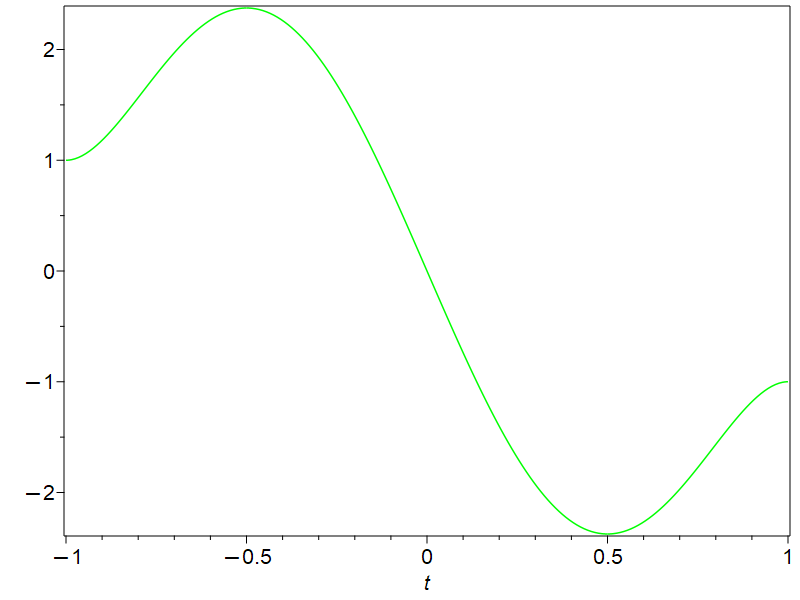

In [12]:
pB := BHBIP( rho, nodes, t ):
plot( pB, t=-1..1, colour=green );

In [15]:
(A,B) := CMP( rhoB, nodes, t );

In [16]:
Digits := 15:
LinearAlgebra:-Eigenvalues( evalf(A), evalf(B) );